In [1]:
import pandas as pd
import duckdb
import re

In [2]:
df_damage_reports: pd.DataFrame = pd.read_csv("/Users/nathanngo/Projects/test/test/data/damage_reports.csv")
df_inspections: pd.DataFrame = pd.read_csv("/Users/nathanngo/Projects/test/test/data/inspections.csv")
df_inspectors: pd.DataFrame = pd.read_csv("/Users/nathanngo/Projects/test/test/data/inspectors.csv")
df_vehicles: pd.DataFrame = pd.read_csv("/Users/nathanngo/Projects/test/test/data/vehicles.csv")

In [3]:
conn: duckdb.DuckDBPyConnection = duckdb.connect("paveai.duckdb")

In [4]:
# Register the DataFrame as a DuckDB view
conn.register('df_damage_reports', df_damage_reports)
conn.register('df_inspections', df_inspections)
conn.register('df_inspectors', df_inspectors)
conn.register('df_vehicles', df_vehicles)

## 1. Validate VIN formats

The car's vehicle identification number (VIN) is the identifying code for a SPECIFIC automobile. The VIN serves as the car's fingerprint, as no two vehicles in operation have the same VIN. A VIN is composed of 17 characters (digits and capital letters) that act as a unique identifier for the vehicle. [vin-basis](https://www.autocheck.com/vehiclehistory/vin-basics)

**Format Validation**:
- Length:
A valid VIN must be 17 characters long for vehicles manufactured since 1981.
- Allowed Characters:
VINs consist of digits (0-9) and capital letters (A-Z). The letters 'I', 'O', and 'Q' are specifically excluded.


### 1.1 Python logic

In [5]:
def _check_vin_format(text: str) -> bool:
    if not isinstance(text, str):
        return False
    
    text = text.strip()
    vin_regex: re.Pattern = re.compile(r'^[A-HJ-NPR-Z0-9]{17}$')
    return bool(vin_regex.match(text))

In [6]:
df = df_inspections.copy()
df["vehicle_vin_validation"] = df["vehicle_vin"].apply(lambda x: _check_vin_format(x))

In [7]:
df[["vehicle_vin", "vehicle_vin_validation"]].head()

,vehicle_vin,vehicle_vin_validation
0,WKJAAHPMU6PFAAPBE,True
1,IHVI2QDMPBA5S6ERA,False
2,6ZTEFEHX2BT869595,True
3,7DKEH1SDIZKA1OZK2,False
4,UZL8NWLXHUMLBQG0G,False


### 1.2 SQL logic

In [8]:
df = df_inspections.copy()

sql: str = """
SELECT
    *,
    CASE
        WHEN 
            TRIM(vehicle_vin) ~ '^[A-HJ-NPR-Z0-9]{17}$' 
        THEN 
            TRUE
        ELSE 
            FALSE
    END AS vehicle_vin_validation
FROM
    df
"""
df = duckdb.query(sql).fetchdf()

In [9]:
df[["vehicle_vin", "vehicle_vin_validation"]].head()

,vehicle_vin,vehicle_vin_validation
0,WKJAAHPMU6PFAAPBE,True
1,IHVI2QDMPBA5S6ERA,False
2,6ZTEFEHX2BT869595,True
3,7DKEH1SDIZKA1OZK2,False
4,UZL8NWLXHUMLBQG0G,False


## 2. Check for Missing Critical Fields

Critical fields to check:

inspections.inspection_id, vehicle_vin, inspector_id, inspection_date

inspectors.name, vehicles.make, damage_reports.damage_type, severity

In [ ]:
# Inspections with missing critical fields
sql: str = """
SELECT *
FROM df_inspections
WHERE inspection_id IS NULL
   OR vehicle_vin IS NULL
   OR inspector_id IS NULL
   OR inspection_date IS NULL;
"""
duckdb.query(sql).fetchdf()

,inspection_id,vehicle_vin,inspector_id,inspection_date,location_lat,location_lon,status,duration_minutes


In [12]:
# Inspectors with missing names
sql: str = """
SELECT *
FROM df_inspectors
WHERE name IS NULL;

"""
duckdb.query(sql).fetchdf()

,inspector_id,name,region,experience_level,certification_date,inspections_completed


In [14]:
# Vehicles with missing make
sql: str = """
SELECT *
FROM df_vehicles
WHERE make IS NULL;

"""
duckdb.query(sql).fetchdf()

,vin,make,model,year,body_type,current_mileage,market_value


In [15]:
# Damage reports with missing damage_type or severity
sql: str = """
SELECT *
FROM df_damage_reports
WHERE damage_type IS NULL
   OR severity IS NULL;
"""
duckdb.query(sql).fetchdf()

,report_id,inspection_id,damage_type,severity,estimated_cost,part_affected,image_count


In [16]:
import pandas as pd

# Assume you loaded the tables as DataFrames
missing_inspections = df_inspections[
    df_inspections[["inspection_id", "vehicle_vin", "inspector_id", "inspection_date"]].isnull().any(axis=1)
]

missing_inspectors = df_inspectors[df_inspectors["name"].isnull()]
missing_vehicles = df_vehicles[df_vehicles["make"].isnull()]
missing_damages = df_damage_reports[
    df_damage_reports[["damage_type", "severity"]].isnull().any(axis=1)
]


## 3 Identify Duplicate Inspections
Because the inspection_id is PK so it can not be duplicated. Therefore, duplicates are typically detected by the same inspector, vehicle, and timestamp.

In [17]:
sql: str = """
SELECT vehicle_vin, inspector_id, inspection_date, COUNT(*) as duplicate_count
FROM df_inspections
GROUP BY vehicle_vin, inspector_id, inspection_date
HAVING COUNT(*) > 1;
"""
duckdb.query(sql).fetchdf()

,vehicle_vin,inspector_id,inspection_date,duplicate_count


In [20]:
duplicates = df_inspections.groupby(
    ["vehicle_vin", "inspector_id", "inspection_date"]
).size().reset_index(name="count")

duplicate_inspections = duplicates[duplicates["count"] > 1]
print(duplicate_inspections)

Empty DataFrame
Columns: [vehicle_vin, inspector_id, inspection_date, count]
Index: []


## 4. Flag Anomalous Inspection Durations

Assuming Flag Anomalous Inspection Durations --> inspection records where the duration_minutes value is unusually short or long, indicating potential data quality issues or operational anomalies.

Because of lacking domain knowledge --> I applied statistical methods - Interquartile Range (IQR)

Flags durations outside the "normal" range (Q1 - 1.5IQR, Q3 + 1.5IQR)

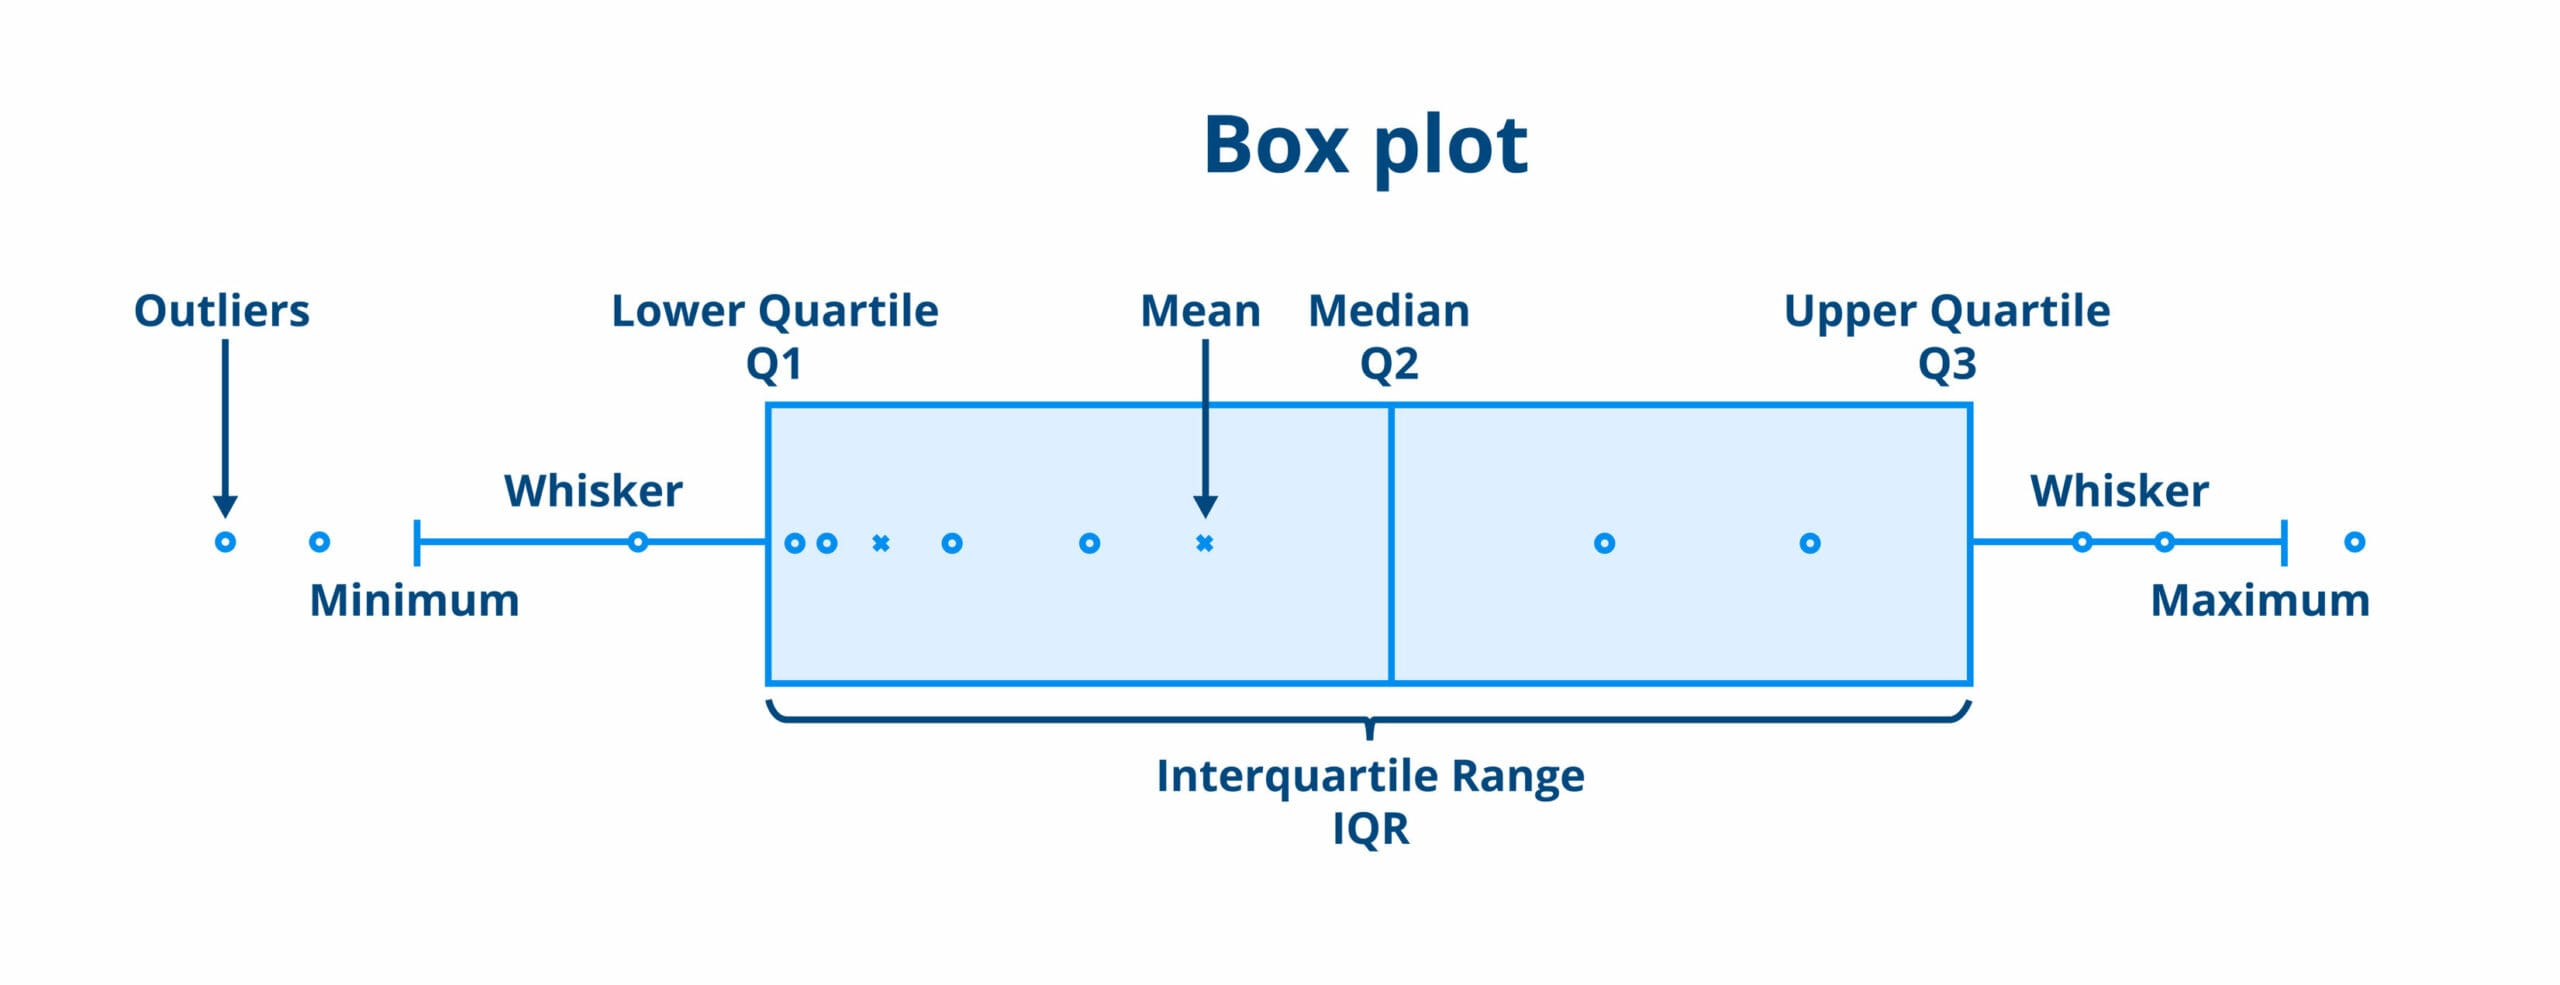

In [ ]:
sql: str = """
WITH percentiles AS (
    SELECT 
        quantile_cont(duration_minutes, 0.25) AS q1,
        quantile_cont(duration_minutes, 0.75) AS q3
    FROM df_inspections
),
bounds AS (
    SELECT 
        q1,
        q3,
        (q3 - q1) AS iqr,
        q1 - 1.5 * (q3 - q1) AS lower_bound,
        q3 + 1.5 * (q3 - q1) AS upper_bound
    FROM percentiles
),
flagged AS (
    SELECT 
        i.*,
        b.lower_bound,
        b.upper_bound,
        CASE 
            WHEN 
                i.duration_minutes < b.lower_bound 
                OR i.duration_minutes > b.upper_bound 
                THEN 
                    TRUE 
            ELSE 
                FALSE 
        END AS is_anomaly
    FROM df_inspections i
    CROSS JOIN bounds b
)
SELECT *
FROM flagged
WHERE is_anomaly = TRUE;

"""
duckdb.query(sql).fetchdf()

,inspection_id,vehicle_vin,inspector_id,inspection_date,location_lat,location_lon,status,duration_minutes,lower_bound,upper_bound,is_anomaly


In [24]:
q1 = df_inspections["duration_minutes"].quantile(0.25)
q3 = df_inspections["duration_minutes"].quantile(0.75)
IQR = q3 - q1

lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

df_anomalies = df_inspections[
    (df_inspections["duration_minutes"] < lower_bound) |
    (df_inspections["duration_minutes"] > upper_bound)
]
print(df_anomalies)

Empty DataFrame
Columns: [inspection_id, vehicle_vin, inspector_id, inspection_date, location_lat, location_lon, status, duration_minutes]
Index: []
